## Classifying Good Product Reviews: Deep Learning Model

**Team J Cubed**: James Wei, Jessica Ko, Jay Patel

CS 294-129, Fall 2016

**NOTE:** Most of the code for data handling, featurization, and model construction lies outside of this notebook. Please see the Python scripts in {src_root}/lib for exact implementation details.

### Organize imports

In [1]:
from __future__ import division, print_function, absolute_import
from gensim.models import Word2Vec
from lib.amazon_model import *
from lib.data_mgmt import *
from nltk.data import find
from sklearn.metrics import roc_curve, auc

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%load_ext autoreload
%autoreload 2

### Set network parameters

In [2]:
# Dataset/Featurization Config
path = 'data/good_fullcols.csv'
label = 'good'
max_size = 200
max_tfidf = 12000
n_classes = 2
n_features = 300
test_size = 0.25
verbose = True

# LSTM Config
lstm_size = 50
num_lstm_layers = 2
lstm_dropout = 0.15

# FC Config
fc_layer_sizes = [75, 50, 30]
fc_dropout = 0.10

# Training config
run_name = 'genesisgood_run1'
learning_rate = 1e-3
reg_weight = 1e-5
training_iters = 15000 * 10
batch_size = 15
display_step = 10
save_every = 5000
save_fn = 'chkpts/model_' + run_name + '.ckpt'
should_log_metrics = True

In [3]:
training_loss_iter_fn = 'log/training_loss_iter_' + run_name + '.csv'
training_acc_iter_fn = 'log/training_acc_iter_' + run_name + '.csv'
testing_loss_iter_fn = 'log/testing_loss_iter_' + run_name + '.csv'
testing_acc_iter_fn = 'log/testing_acc_iter_' + run_name + '.csv'

### Set up word embedding model

In [4]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
we_model = gensim.models.Word2Vec.load_word2vec_format(word2vec_sample, binary=False)

### Configure dataset

In [5]:
dataset = Dataset(path, we_model, {
    'label'      : label,
    'max_size'   : max_size,
    'max_tfidf'  : max_tfidf,
    'n_features' : n_features,
    'test_size'  : test_size,
    'verbose'    : verbose
})

n_cols = dataset.get_n_cols() # Number of additional DNN features (including tf-idf features)

Initializing dataset at data/supermin_good_20k_fullcols.csv.
Splitting training and test sets.
Building reviewer/ASIN maps.
Fitting tf-idf featurizer.
Tuning tf-idf classifier.
Featurizing training set.
Featurizing test set.
Finished configuring dataset.


### Prepare model configurations

In [6]:
class ModelConfig(object):
    def __init__(self):
        self.lstm_size = lstm_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm_keep_prob = 1.0 - lstm_dropout
        self.fc_keep_prob = 1.0 - fc_dropout
        self.learning_rate = learning_rate
        self.reg_weight = reg_weight
        self.fc_layer_sizes = fc_layer_sizes
        self.n_classes = n_classes
        self.n_cols = n_cols
        self.n_fc_layers = len(fc_layer_sizes) + 1

config = ModelConfig()

### Set up Tensorflow Graph

In [7]:
tf.reset_default_graph()

amazon_model = AmazonModel(config)
pred = amazon_model.build_graph()

In [8]:
# Input placeholders
x = tf.placeholder("float", [None, max_size, n_features])
x2 = tf.placeholder("float", [None, n_cols])
seqlen = tf.placeholder(tf.int32, [None])
lstm_keep_prob = tf.placeholder(tf.float32)
fc_keep_prob = tf.placeholder(tf.float32)

# Output placeholder
y = tf.placeholder("float", [None, n_classes])

# Checkpointing
saver = tf.train.Saver()

In [9]:
# Run forward pass
logits = pred(x, x2, seqlen, lstm_keep_prob, fc_keep_prob)

# Define loss and optimizer
cost = tf.add(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y)),
              amazon_model.regularization_penalty())

optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

/Users/jwei/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [10]:
# Initializing the variables
init = tf.initialize_all_variables()

### Train model

In [11]:
if should_log_metrics:
    train_loss_log = open(training_loss_iter_fn, 'a')
    test_loss_log = open(testing_loss_iter_fn, 'a')
    train_acc_log = open(training_acc_iter_fn, 'a')
    test_acc_log = open(testing_acc_iter_fn, 'a')

Iter 150, Minibatch Loss= 0.631192, Training Accuracy= 0.46667
Iter 300, Minibatch Loss= 0.856761, Training Accuracy= 0.46667
Iter 450, Minibatch Loss= 0.683990, Training Accuracy= 0.66667
Iter 600, Minibatch Loss= 0.584971, Training Accuracy= 0.66667
Iter 750, Minibatch Loss= 0.586530, Training Accuracy= 0.66667
Validation Accuracy: 0.6604
Validation Loss: 0.653118


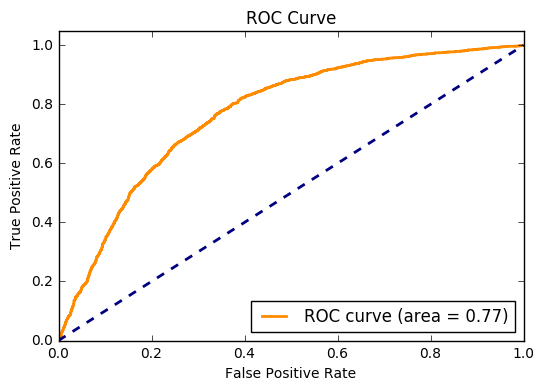

Iter 900, Minibatch Loss= 0.580542, Training Accuracy= 0.80000
Iter 1050, Minibatch Loss= 0.549753, Training Accuracy= 0.86667
Iter 1200, Minibatch Loss= 0.644903, Training Accuracy= 0.53333
Iter 1350, Minibatch Loss= 0.543284, Training Accuracy= 0.80000
Iter 1500, Minibatch Loss= 0.622796, Training Accuracy= 0.53333
Validation Accuracy: 0.6088
Validation Loss: 0.63896
Iter 1650, Minibatch Loss= 0.592779, Training Accuracy= 0.60000
Iter 1800, Minibatch Loss= 0.418764, Training Accuracy= 0.73333
Iter 1950, Minibatch Loss= 0.738673, Training Accuracy= 0.60000
Iter 2100, Minibatch Loss= 0.626026, Training Accuracy= 0.66667
Iter 2250, Minibatch Loss= 0.550650, Training Accuracy= 0.66667
Validation Accuracy: 0.7142
Validation Loss: 0.582906


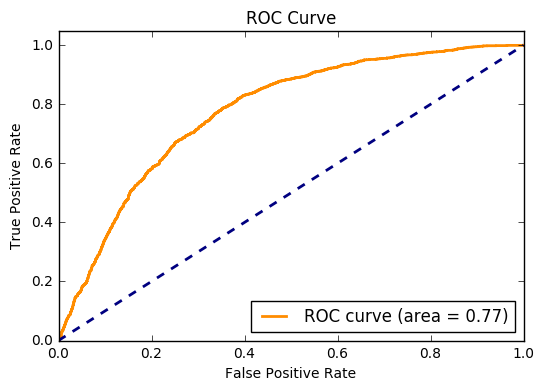

Iter 2400, Minibatch Loss= 0.527633, Training Accuracy= 0.73333
Iter 2550, Minibatch Loss= 0.547814, Training Accuracy= 0.66667
Iter 2700, Minibatch Loss= 0.610643, Training Accuracy= 0.66667
Iter 2850, Minibatch Loss= 0.599434, Training Accuracy= 0.60000
Iter 3000, Minibatch Loss= 0.568005, Training Accuracy= 0.80000
Validation Accuracy: 0.7174
Validation Loss: 0.586541


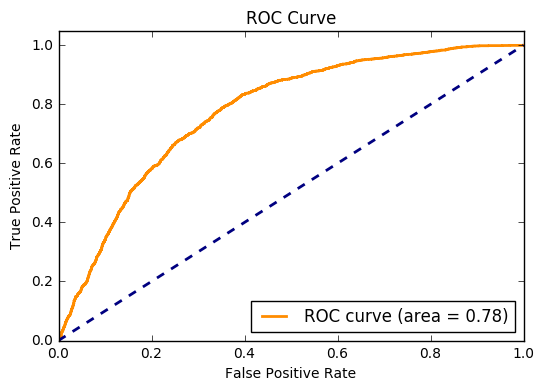

Iter 3150, Minibatch Loss= 0.481527, Training Accuracy= 0.66667
Iter 3300, Minibatch Loss= 0.711170, Training Accuracy= 0.66667
Iter 3450, Minibatch Loss= 0.517649, Training Accuracy= 0.80000
Iter 3600, Minibatch Loss= 0.768518, Training Accuracy= 0.46667
Iter 3750, Minibatch Loss= 0.598279, Training Accuracy= 0.60000
Validation Accuracy: 0.7214
Validation Loss: 0.575151


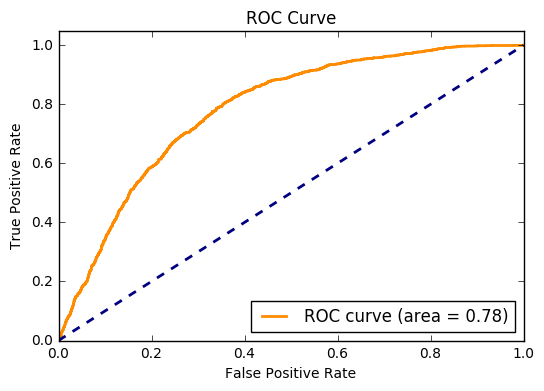

Iter 3900, Minibatch Loss= 0.572397, Training Accuracy= 0.73333
Iter 4050, Minibatch Loss= 0.598642, Training Accuracy= 0.66667
Iter 4200, Minibatch Loss= 0.621565, Training Accuracy= 0.60000
Iter 4350, Minibatch Loss= 0.525786, Training Accuracy= 0.86667
Iter 4500, Minibatch Loss= 0.571908, Training Accuracy= 0.80000
Validation Accuracy: 0.7216
Validation Loss: 0.569306


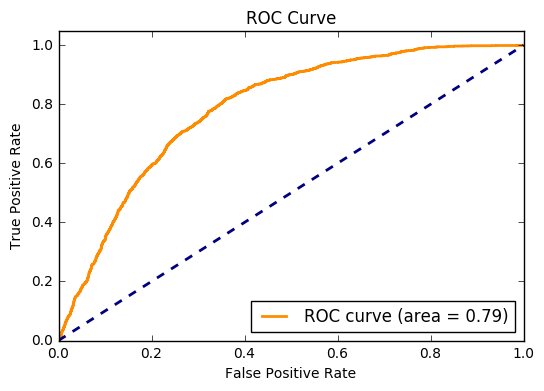

Iter 4650, Minibatch Loss= 0.651834, Training Accuracy= 0.53333
Iter 4800, Minibatch Loss= 0.447565, Training Accuracy= 0.93333
Iter 4950, Minibatch Loss= 0.367350, Training Accuracy= 0.93333
Iter 5100, Minibatch Loss= 0.368156, Training Accuracy= 0.93333
Iter 5250, Minibatch Loss= 0.633304, Training Accuracy= 0.60000
Validation Accuracy: 0.7152
Validation Loss: 0.566436
Iter 5400, Minibatch Loss= 0.652770, Training Accuracy= 0.46667
Iter 5550, Minibatch Loss= 0.645159, Training Accuracy= 0.66667
Iter 5700, Minibatch Loss= 0.586868, Training Accuracy= 0.66667
Iter 5850, Minibatch Loss= 0.512882, Training Accuracy= 0.80000
Iter 6000, Minibatch Loss= 0.698787, Training Accuracy= 0.66667
Validation Accuracy: 0.6934
Validation Loss: 0.583632
Iter 6150, Minibatch Loss= 0.530217, Training Accuracy= 0.66667
Iter 6300, Minibatch Loss= 0.449798, Training Accuracy= 0.80000
Iter 6450, Minibatch Loss= 0.657260, Training Accuracy= 0.60000
Iter 6600, Minibatch Loss= 0.735772, Training Accuracy= 0.53

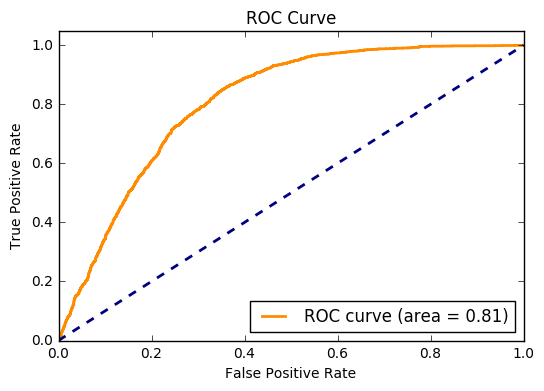

Iter 6900, Minibatch Loss= 0.536327, Training Accuracy= 0.80000
Iter 7050, Minibatch Loss= 0.666843, Training Accuracy= 0.46667
Iter 7200, Minibatch Loss= 0.592248, Training Accuracy= 0.60000
Iter 7350, Minibatch Loss= 0.617988, Training Accuracy= 0.73333
Iter 7500, Minibatch Loss= 0.422397, Training Accuracy= 0.93333
Validation Accuracy: 0.7166
Validation Loss: 0.552303
Iter 7650, Minibatch Loss= 0.431389, Training Accuracy= 0.80000
Iter 7800, Minibatch Loss= 0.669104, Training Accuracy= 0.66667
Iter 7950, Minibatch Loss= 0.436929, Training Accuracy= 0.80000
Iter 8100, Minibatch Loss= 0.475441, Training Accuracy= 0.80000
Iter 8250, Minibatch Loss= 0.532236, Training Accuracy= 0.80000
Validation Accuracy: 0.7202
Validation Loss: 0.552797
Iter 8400, Minibatch Loss= 0.590532, Training Accuracy= 0.66667
Iter 8550, Minibatch Loss= 0.552834, Training Accuracy= 0.73333
Iter 8700, Minibatch Loss= 0.617815, Training Accuracy= 0.66667
Iter 8850, Minibatch Loss= 0.595786, Training Accuracy= 0.73

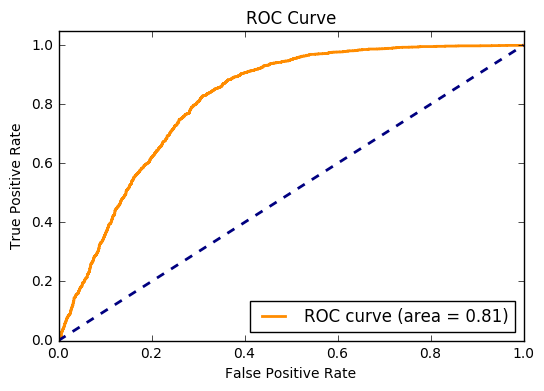

Iter 10650, Minibatch Loss= 0.675785, Training Accuracy= 0.73333
Iter 10800, Minibatch Loss= 0.310681, Training Accuracy= 0.80000
Iter 10950, Minibatch Loss= 0.442064, Training Accuracy= 0.86667
Iter 11100, Minibatch Loss= 0.493427, Training Accuracy= 0.86667
Iter 11250, Minibatch Loss= 0.402433, Training Accuracy= 0.86667
Validation Accuracy: 0.7514
Validation Loss: 0.536461
Iter 11400, Minibatch Loss= 0.614560, Training Accuracy= 0.60000
Iter 11550, Minibatch Loss= 0.591647, Training Accuracy= 0.53333
Iter 11700, Minibatch Loss= 0.685847, Training Accuracy= 0.66667
Iter 11850, Minibatch Loss= 0.566316, Training Accuracy= 0.66667
Iter 12000, Minibatch Loss= 0.547506, Training Accuracy= 0.80000
Validation Accuracy: 0.7396
Validation Loss: 0.5249
Iter 12150, Minibatch Loss= 0.537211, Training Accuracy= 0.73333
Iter 12300, Minibatch Loss= 0.280715, Training Accuracy= 1.00000
Iter 12450, Minibatch Loss= 0.477496, Training Accuracy= 0.73333
Iter 12600, Minibatch Loss= 0.372822, Training Ac

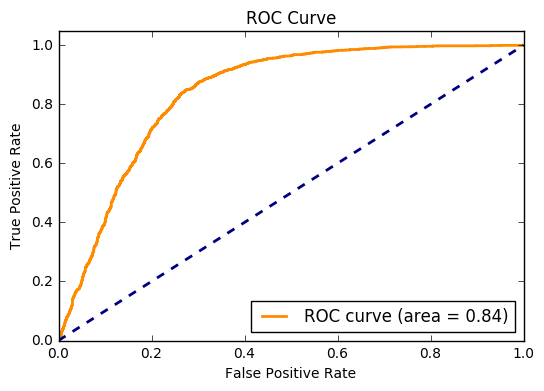

Iter 14400, Minibatch Loss= 0.445255, Training Accuracy= 0.80000
Iter 14550, Minibatch Loss= 0.280012, Training Accuracy= 0.93333
Iter 14700, Minibatch Loss= 0.455646, Training Accuracy= 0.80000
Iter 14850, Minibatch Loss= 0.547956, Training Accuracy= 0.73333
Iter 15000, Minibatch Loss= 0.666060, Training Accuracy= 0.60000
Validation Accuracy: 0.7666
Validation Loss: 0.50631
Iter 15150, Minibatch Loss= 0.285162, Training Accuracy= 0.93333
Iter 15300, Minibatch Loss= 0.504627, Training Accuracy= 0.73333
Iter 15450, Minibatch Loss= 0.480253, Training Accuracy= 0.80000
Iter 15600, Minibatch Loss= 0.428919, Training Accuracy= 0.73333
Iter 15750, Minibatch Loss= 0.294873, Training Accuracy= 0.93333
Validation Accuracy: 0.774
Validation Loss: 0.492433
Iter 15900, Minibatch Loss= 0.432683, Training Accuracy= 0.86667
Iter 16050, Minibatch Loss= 0.556215, Training Accuracy= 0.66667
Iter 16200, Minibatch Loss= 0.616836, Training Accuracy= 0.66667
Iter 16350, Minibatch Loss= 0.455589, Training Ac

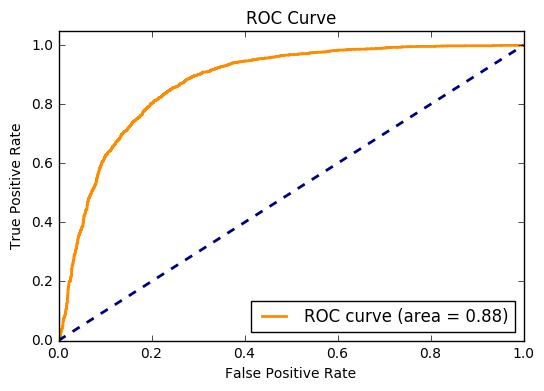

Iter 17400, Minibatch Loss= 0.577665, Training Accuracy= 0.66667
Iter 17550, Minibatch Loss= 0.275529, Training Accuracy= 0.86667
Iter 17700, Minibatch Loss= 0.742412, Training Accuracy= 0.53333
Iter 17850, Minibatch Loss= 0.562419, Training Accuracy= 0.60000
Iter 18000, Minibatch Loss= 0.453546, Training Accuracy= 0.80000
Validation Accuracy: 0.721
Validation Loss: 0.538197
Iter 18150, Minibatch Loss= 0.567297, Training Accuracy= 0.60000
Iter 18300, Minibatch Loss= 0.641257, Training Accuracy= 0.60000
Iter 18450, Minibatch Loss= 0.412094, Training Accuracy= 0.86667
Iter 18600, Minibatch Loss= 0.645921, Training Accuracy= 0.53333
Iter 18750, Minibatch Loss= 0.562378, Training Accuracy= 0.60000
Validation Accuracy: 0.7654
Validation Loss: 0.516015
Iter 18900, Minibatch Loss= 0.415517, Training Accuracy= 0.86667
Iter 19050, Minibatch Loss= 0.579332, Training Accuracy= 0.66667
Iter 19200, Minibatch Loss= 0.439924, Training Accuracy= 0.66667
Iter 19350, Minibatch Loss= 0.425454, Training A

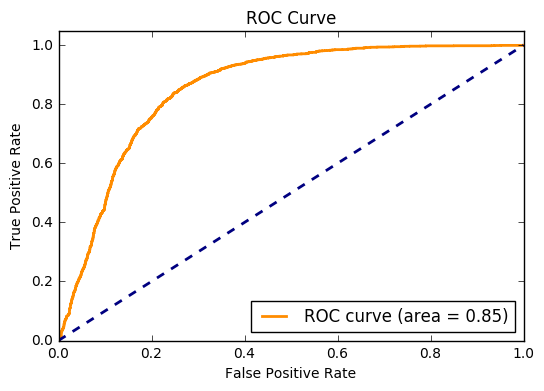

Iter 27150, Minibatch Loss= 0.454659, Training Accuracy= 0.80000
Iter 27300, Minibatch Loss= 0.248732, Training Accuracy= 1.00000
Iter 27450, Minibatch Loss= 0.435626, Training Accuracy= 0.80000
Iter 27600, Minibatch Loss= 0.308786, Training Accuracy= 0.93333
Iter 27750, Minibatch Loss= 0.446873, Training Accuracy= 0.73333
Validation Accuracy: 0.7254
Validation Loss: 0.533793
Iter 27900, Minibatch Loss= 0.219261, Training Accuracy= 0.93333
Iter 28050, Minibatch Loss= 0.536504, Training Accuracy= 0.80000
Iter 28200, Minibatch Loss= 0.458417, Training Accuracy= 0.80000
Iter 28350, Minibatch Loss= 0.296857, Training Accuracy= 0.93333
Iter 28500, Minibatch Loss= 0.359527, Training Accuracy= 0.80000
Validation Accuracy: 0.7264
Validation Loss: 0.554467
Iter 28650, Minibatch Loss= 0.948171, Training Accuracy= 0.46667
Iter 28800, Minibatch Loss= 0.327767, Training Accuracy= 1.00000
Iter 28950, Minibatch Loss= 0.486352, Training Accuracy= 0.73333
Iter 29100, Minibatch Loss= 1.021784, Training 

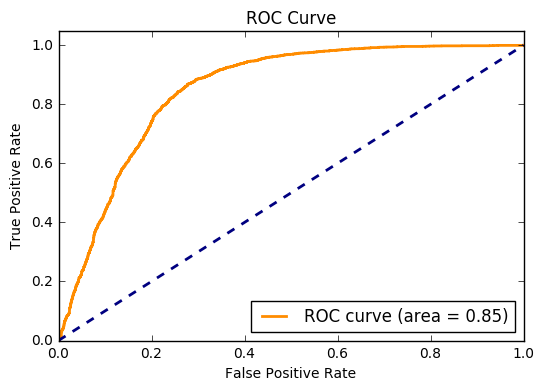

Iter 29400, Minibatch Loss= 0.425919, Training Accuracy= 0.80000
Iter 29550, Minibatch Loss= 0.268918, Training Accuracy= 0.93333
Iter 29700, Minibatch Loss= 0.460246, Training Accuracy= 0.80000
Iter 29850, Minibatch Loss= 0.498051, Training Accuracy= 0.73333
Iter 30000, Minibatch Loss= 0.735690, Training Accuracy= 0.60000
Validation Accuracy: 0.7948
Validation Loss: 0.465849


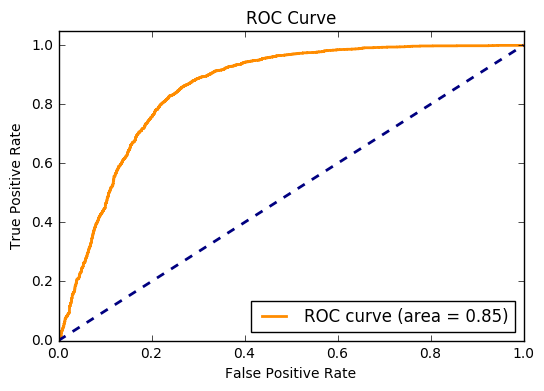

Iter 30150, Minibatch Loss= 0.195852, Training Accuracy= 1.00000
Iter 30300, Minibatch Loss= 0.509631, Training Accuracy= 0.66667
Iter 30450, Minibatch Loss= 0.477391, Training Accuracy= 0.73333
Iter 30600, Minibatch Loss= 0.447023, Training Accuracy= 0.80000
Iter 30750, Minibatch Loss= 0.308420, Training Accuracy= 0.93333
Validation Accuracy: 0.7692
Validation Loss: 0.487998
Iter 30900, Minibatch Loss= 0.396414, Training Accuracy= 0.86667
Iter 31050, Minibatch Loss= 0.427664, Training Accuracy= 0.80000
Iter 31200, Minibatch Loss= 0.721073, Training Accuracy= 0.66667
Iter 31350, Minibatch Loss= 0.444300, Training Accuracy= 0.80000
Iter 31500, Minibatch Loss= 0.375626, Training Accuracy= 0.86667
Validation Accuracy: 0.7826
Validation Loss: 0.479423
Iter 31650, Minibatch Loss= 0.427931, Training Accuracy= 0.86667
Iter 31800, Minibatch Loss= 0.379424, Training Accuracy= 0.80000
Iter 31950, Minibatch Loss= 0.441994, Training Accuracy= 0.73333
Iter 32100, Minibatch Loss= 0.446612, Training 

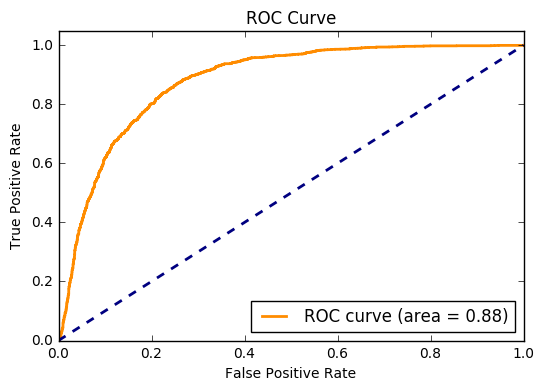

Iter 36150, Minibatch Loss= 0.450839, Training Accuracy= 0.73333
Iter 36300, Minibatch Loss= 0.432052, Training Accuracy= 0.73333
Iter 36450, Minibatch Loss= 0.342238, Training Accuracy= 0.93333
Iter 36600, Minibatch Loss= 0.831615, Training Accuracy= 0.60000
Iter 36750, Minibatch Loss= 0.302123, Training Accuracy= 0.80000
Validation Accuracy: 0.7826
Validation Loss: 0.471487
Iter 36900, Minibatch Loss= 0.379044, Training Accuracy= 0.86667
Iter 37050, Minibatch Loss= 0.340010, Training Accuracy= 0.86667
Iter 37200, Minibatch Loss= 0.471632, Training Accuracy= 0.73333
Iter 37350, Minibatch Loss= 0.290347, Training Accuracy= 0.93333
Iter 37500, Minibatch Loss= 0.252179, Training Accuracy= 1.00000
Validation Accuracy: 0.7976
Validation Loss: 0.4537
Iter 37650, Minibatch Loss= 0.456918, Training Accuracy= 0.80000
Iter 37800, Minibatch Loss= 0.624120, Training Accuracy= 0.73333
Iter 37950, Minibatch Loss= 0.276486, Training Accuracy= 1.00000
Iter 38100, Minibatch Loss= 0.269876, Training Ac

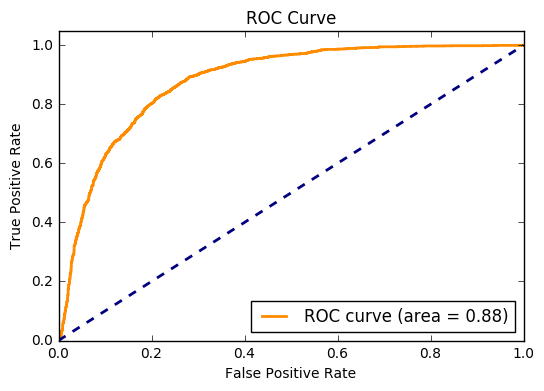

Iter 57150, Minibatch Loss= 0.418182, Training Accuracy= 0.80000
Iter 57300, Minibatch Loss= 0.286614, Training Accuracy= 0.86667
Iter 57450, Minibatch Loss= 0.461671, Training Accuracy= 0.80000
Iter 57600, Minibatch Loss= 0.360391, Training Accuracy= 0.86667
Iter 57750, Minibatch Loss= 0.419331, Training Accuracy= 0.80000
Validation Accuracy: 0.7696
Validation Loss: 0.489685
Iter 57900, Minibatch Loss= 0.206553, Training Accuracy= 0.93333
Iter 58050, Minibatch Loss= 0.461353, Training Accuracy= 0.86667
Iter 58200, Minibatch Loss= 0.314890, Training Accuracy= 0.86667
Iter 58350, Minibatch Loss= 0.221927, Training Accuracy= 0.93333
Iter 58500, Minibatch Loss= 0.210825, Training Accuracy= 0.86667
Validation Accuracy: 0.7966
Validation Loss: 0.452212
Iter 58650, Minibatch Loss= 0.607581, Training Accuracy= 0.73333
Iter 58800, Minibatch Loss= 0.249140, Training Accuracy= 0.86667
Iter 58950, Minibatch Loss= 0.358514, Training Accuracy= 0.80000
Iter 59100, Minibatch Loss= 0.852601, Training 

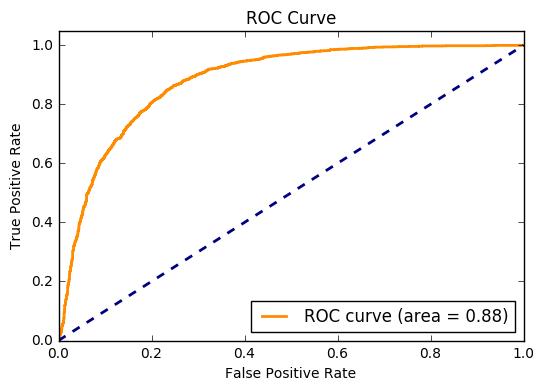

Iter 66900, Minibatch Loss= 0.207823, Training Accuracy= 1.00000
Iter 67050, Minibatch Loss= 0.233490, Training Accuracy= 0.93333
Iter 67200, Minibatch Loss= 0.384473, Training Accuracy= 0.86667
Iter 67350, Minibatch Loss= 0.241949, Training Accuracy= 0.93333
Iter 67500, Minibatch Loss= 0.170116, Training Accuracy= 1.00000
Validation Accuracy: 0.7986
Validation Loss: 0.447901
Iter 67650, Minibatch Loss= 0.428537, Training Accuracy= 0.80000
Iter 67800, Minibatch Loss= 0.603912, Training Accuracy= 0.73333
Iter 67950, Minibatch Loss= 0.276566, Training Accuracy= 1.00000
Iter 68100, Minibatch Loss= 0.280750, Training Accuracy= 0.93333
Iter 68250, Minibatch Loss= 0.446599, Training Accuracy= 0.80000
Validation Accuracy: 0.7958
Validation Loss: 0.456464
Iter 68400, Minibatch Loss= 0.420459, Training Accuracy= 0.80000
Iter 68550, Minibatch Loss= 0.344040, Training Accuracy= 0.86667
Iter 68700, Minibatch Loss= 0.593581, Training Accuracy= 0.80000
Iter 68850, Minibatch Loss= 0.512697, Training 

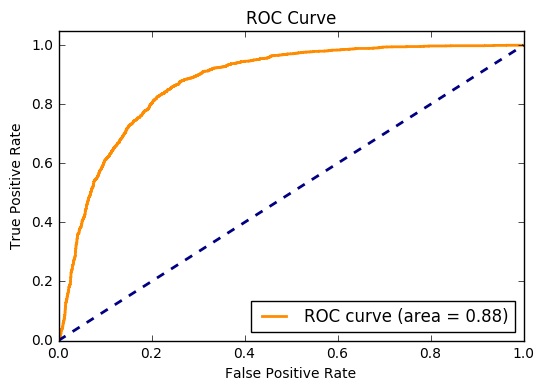

Checkpoint saved at chkpts/model_genesisgood_run1.ckpt
Iter 75150, Minibatch Loss= 0.168864, Training Accuracy= 1.00000
Iter 75300, Minibatch Loss= 0.497639, Training Accuracy= 0.73333
Iter 75450, Minibatch Loss= 0.303428, Training Accuracy= 0.93333
Iter 75600, Minibatch Loss= 0.302167, Training Accuracy= 0.86667
Iter 75750, Minibatch Loss= 0.222894, Training Accuracy= 0.93333
Validation Accuracy: 0.8064
Validation Loss: 0.437343
Iter 75900, Minibatch Loss= 0.441154, Training Accuracy= 0.80000
Iter 76050, Minibatch Loss= 0.206166, Training Accuracy= 1.00000
Iter 76200, Minibatch Loss= 0.634717, Training Accuracy= 0.66667
Iter 76350, Minibatch Loss= 0.498130, Training Accuracy= 0.80000
Iter 76500, Minibatch Loss= 0.277773, Training Accuracy= 0.93333
Validation Accuracy: 0.749
Validation Loss: 0.519836
Iter 76650, Minibatch Loss= 0.385174, Training Accuracy= 0.80000
Iter 76800, Minibatch Loss= 0.338667, Training Accuracy= 0.86667
Iter 76950, Minibatch Loss= 0.493274, Training Accuracy= 0

In [12]:
best_test_acc = -1.0
sess = tf.Session()

# Launch the graph
if True:
    sess.run(init)
    test_data, test_label, test_seqlen, test_dnn = dataset.get_test_batch()
    test_dict = {
        x: test_data, 
        y: test_label,
        seqlen: test_seqlen, 
        x2: test_dnn,
        lstm_keep_prob: 1.00,
        fc_keep_prob: 1.00
    }
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen, batch_dnn = dataset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={
            x: batch_x, 
            y: batch_y,
            seqlen: batch_seqlen, 
            x2: batch_dnn,
            lstm_keep_prob: config.lstm_keep_prob,
            fc_keep_prob: config.fc_keep_prob
        })
        
        eval_dict = {
            x:      batch_x, 
            y:      batch_y,
            seqlen: batch_seqlen, 
            x2:     batch_dnn,
            lstm_keep_prob: 1.00,
            fc_keep_prob:   1.00
        }
        
        if should_log_metrics:
            acc = sess.run(accuracy, feed_dict=eval_dict)
            loss = sess.run(cost, feed_dict=eval_dict)
            line_start = str(step*batch_size) + ","
            train_loss_log.write(line_start + str(loss) + '\n')
            train_loss_log.flush()
            train_acc_log.write(line_start + str(acc) + '\n')
            train_acc_log.flush()

        if step % display_step == 0:
            if not should_log_metrics:
                acc = sess.run(accuracy, feed_dict=eval_dict)
                loss = sess.run(cost, feed_dict=eval_dict)
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
        if step % (display_step) == 0:
            if should_log_metrics:
                test_acc = sess.run(accuracy, feed_dict=test_dict)
                test_loss = sess.run(cost, feed_dict=test_dict)
                test_loss_log.write(line_start + str(test_loss) + '\n')
                test_loss_log.flush()
                test_acc_log.write(line_start + str(test_acc) + '\n')
                test_acc_log.flush()        
            if step % (5 * display_step) == 0:
                if not should_log_metrics:
                    test_acc = sess.run(accuracy, feed_dict=test_dict)
                    test_loss = sess.run(cost, feed_dict=test_dict)
                print("Validation Accuracy:", test_acc)
                print("Validation Loss:", test_loss)
                
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    # Plot ROC
                    answers = sess.run(tf.nn.softmax(logits), feed_dict=test_dict)
                    if label == 'good':
                        fpr, tpr, _ = roc_curve(1 - np.argmax(test_label, axis=1), answers[:, 0])
                    else:
                        fpr, tpr, _ = roc_curve(np.argmax(test_label, axis=1), answers[:, 1])
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    lw = 2
                    plt.plot(fpr, tpr, color='darkorange',
                             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC Curve')
                    plt.legend(loc="lower right")
                    plt.show()
        
        if step % save_every == 0:
            save_path = saver.save(sess, save_fn)
            print("Checkpoint saved at %s" % save_path)
        step += 1
    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_fn)
    print("Checkpoint saved at %s" % save_path)

    # Calculate accuracy
    print("Final Testing Accuracy:", sess.run(accuracy, feed_dict=test_dict))